# 5. Term structures and their reference dates

In [1]:
from QuantLib import *

In [2]:
Settings.instance().evaluationDate = Date(3, October, 2014)

**Specifying the reference date of a term structure**

The reference date of a term structure is where it begins. It can be the
evaluation date, but you might also want it to start on the spot date, for instance.

The first is to define it by means of a (possibly null) offset from the current evaluation date; e.g.,
“two business days after the evaluation date” to define it as the spot date, or “no business days” to
define it as the evaluation date itself.

In [3]:
helpers = [ SwapRateHelper(QuoteHandle(SimpleQuote(rate/100.0)),
Period(*tenor), TARGET(),
Annual, Unadjusted,
Thirty360(),
Euribor6M())
for tenor, rate in [((2,Years), 0.201),
((3,Years), 0.258),
((5,Years), 0.464),
((10,Years), 1.151),
((15,Years), 1.588)] ]

In [4]:
curve1 = PiecewiseFlatForward(0, TARGET(), helpers, Actual360())

The second possibility is to specify the reference date explicitly. For instance, the ForwardCurve
class takes a vector of specific dates and the corresponding rates and interpolates between them; the
first passed date is taken as the reference date of the curve.

In [5]:
dates, rates = zip(*curve1.nodes())

In [6]:
zip(dates, rates)

In [7]:
curve2 = ForwardCurve(dates, rates, Actual360())

Both curves are defined over the same range of dates…

In [8]:
print (curve1.referenceDate(), 'to', curve1.maxDate())
print (curve2.referenceDate(), 'to', curve2.maxDate())

October 3rd, 2014 to October 8th, 2029
October 3rd, 2014 to October 8th, 2029


…and return the same rates, whether we ask for a given time (for instance, 5 years)…

In [9]:
print (curve1.zeroRate(5.0, Continuous))
print (curve2.zeroRate(5.0, Continuous))

0.452196 % Actual/360 continuous compounding
0.452196 % Actual/360 continuous compounding


…or for a given date

In [10]:
print (curve1.zeroRate(Date(7, September, 2019), Actual360(), Continuous))
print (curve2.zeroRate(Date(7, September, 2019), Actual360(), Continuous))

0.452196 % Actual/360 continuous compounding
0.452196 % Actual/360 continuous compounding


With the help of a couple more Python modules, we can also plot the whole curve by asking for
rates over a set of times

In [11]:
%%capture
%pylab inline --no-import-all
import matplotlib.pyplot as plot
import pylab
pylab.rcParams['figure.figsize'] = [12, 8]
import numpy

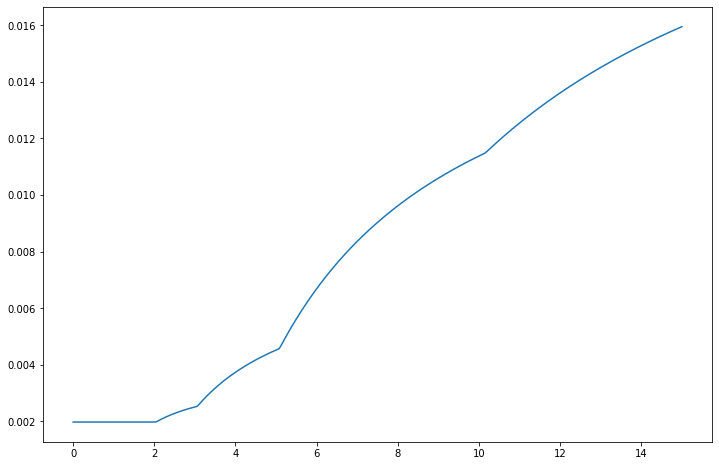

In [12]:
times = numpy.linspace(0.0, 15.0, 400)
rates = [ curve1.zeroRate(t, Continuous).rate() for t in times ]
plot.plot(times, rates)
pass

**Moving the evaluation date**

To recap: we built the first curve specifying its reference date relative to the evaluation date, and the
second curve specifying its reference date explciitly. Now, what happens if we change the evaluation
date?

In [13]:
Settings.instance().evaluationDate = Date(19, September, 2014)

We can see how the range of definition has now changed for the first curve, but not for the second

In [14]:
print (curve1.referenceDate(), 'to', curve1.maxDate())
print (curve2.referenceDate(), 'to', curve2.maxDate())

September 19th, 2014 to September 24th, 2029
October 3rd, 2014 to October 8th, 2029


In [15]:
print (curve1.zeroRate(5.0, Continuous))
print (curve2.zeroRate(5.0, Continuous))

0.452196 % Actual/360 continuous compounding
0.452196 % Actual/360 continuous compounding


In [16]:
print (curve1.zeroRate(Date(7, September, 2019), Actual360(), Continuous))
print (curve2.zeroRate(Date(7, September, 2019), Actual360(), Continuous))

0.454618 % Actual/360 continuous compounding
0.452196 % Actual/360 continuous compounding


# 6. EONIA curve bootstrapping

In [36]:
%%capture
%pylab inline --no-import-all
import math
import plot_utils as pu
from QuantLib import *
import matplotlib.pyplot as plt

In [20]:
today = Date(11, December, 2012)
Settings.instance().evaluationDate = today

The first three instruments are three 1-day deposit that give us discounting between today and the
day after spot. They are modeled by three instances of the DepositRateHelper class with a tenor
of 1 day and a number of fixing days going from 0 (for the deposit starting today) to 2 (for the deposit
starting on the spot date).

In [21]:
helpers = [ DepositRateHelper(QuoteHandle(SimpleQuote(rate/100)),
Period(1,Days), fixingDays,
TARGET(), Following, False, Actual360())
for rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)] ]

Then, we have a series of OIS quotes for the first month. They are modeled by instances of the
OISRateHelper class with varying tenors. They also require an instance of the Eonia class, which
doesn’t need a forecast curve and can be shared between the helpers

In [22]:
eonia = Eonia()

In [23]:
helpers += [ OISRateHelper(2, Period(*tenor),
QuoteHandle(SimpleQuote(rate/100)), eonia)
for rate, tenor in [(0.070, (1,Weeks)), (0.069, (2,Weeks)),
(0.078, (3,Weeks)), (0.074, (1,Months))] ]

Next, five OIS forwards on ECB dates. For these, we need to instantiate the DatedOISRateHelper
class and specify start and end dates explicitly

In [24]:
helpers += [ DatedOISRateHelper(start_date, end_date,
QuoteHandle(SimpleQuote(rate/100)), eonia)
for rate, start_date, end_date in [
(0.046, Date(16,January,2013), Date(13,February,2013)),
(0.016, Date(13,February,2013), Date(13,March,2013)),
(-0.007, Date(13,March,2013), Date(10,April,2013)),
(-0.013, Date(10,April,2013), Date(8,May,2013)),
(-0.014, Date(8,May,2013), Date(12,June,2013))] ]

Finally, we add OIS quotes up to 30 years.

In [25]:
helpers += [ OISRateHelper(2, Period(*tenor),
QuoteHandle(SimpleQuote(rate/100)), eonia)
for rate, tenor in [(0.002, (15,Months)), (0.008, (18,Months)),
(0.021, (21,Months)), (0.036, (2,Years)),
(0.127, (3,Years)), (0.274, (4,Years)),
(0.456, (5,Years)), (0.647, (6,Years)),
(0.827, (7,Years)), (0.996, (8,Years)),
(1.147, (9,Years)), (1.280, (10,Years)),
(1.404, (11,Years)), (1.516, (12,Years)),
(1.764, (15,Years)), (1.939, (20,Years)),
(2.003, (25,Years)), (2.038, (30,Years))] ]

In [26]:
eonia_curve_c = PiecewiseLogCubicDiscount(0, TARGET(),
helpers, Actual365Fixed())
eonia_curve_c.enableExtrapolation()

In [27]:
today = eonia_curve_c.referenceDate()
end = today + Period(2,Years)
dates = [ Date(serial) for serial in range(today.serialNumber(),
end.serialNumber()+1) ]
rates_c = [ eonia_curve_c.forwardRate(d, TARGET().advance(d,1,Days),
Actual360(), Simple).rate()
for d in dates ]

In [ ]:
pu.plot_curve(plt, dates, [(rates_c,'-')])

# 8. Constructing Yield Curve

In [42]:
from QuantLib import *
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
depo_maturities = [Period(6,Months), Period(12, Months)]
depo_rates = [5.25, 5.5]
# Bond rates
bond_maturities = [Period(6*i, Months) for i in range(3,21)]
bond_rates = [5.75, 6.0, 6.25, 6.5, 6.75, 6.80, 7.00, 7.1, 7.15,
7.2, 7.3, 7.35, 7.4, 7.5, 7.6, 7.6, 7.7, 7.8]
maturities = depo_maturities+bond_maturities
rates = depo_rates+bond_rates
DataFrame(zip(maturities, rates) ,
columns=["Maturities","Curve"],
index=['']*len(rates))

In [47]:
calc_date = Date(15, 1, 2015)
Settings.instance().evaluationDate = calc_date
calendar = UnitedStates()
business_convention = Unadjusted
day_count = Thirty360()
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = Period(Semiannual)
settlement_days = 0

The basic idea of bootstrapping is to use the deposit rates and bond rates to create individual rate
helpers. Then use the combination of the two helpers to construct the yield curve. As a first step, we
create the deposit rate helpers as shown below.


In [48]:
depo_helpers = [DepositRateHelper(QuoteHandle(SimpleQuote(r/100.0)),
m,
settlement_days,
calendar,
business_convention,
end_of_month,
day_count )
for r, m in zip(depo_rates, depo_maturities)]

The rest of the points are coupon bonds. We assume that the YTM given for the bonds are all par
rates. So we have bonds with coupon rate same as the YTM. Using this information, we construct
the fixed rate bond helpers below.

In [50]:
bond_helpers = []
for r, m in zip(bond_rates, bond_maturities):
    termination_date = calc_date + m
    schedule = Schedule(calc_date,
    termination_date,
    coupon_frequency,
    calendar,
    business_convention,
    business_convention,
    DateGeneration.Backward,
    end_of_month)
    bond_helper = FixedRateBondHelper(QuoteHandle(SimpleQuote(face_amount)),
    settlement_days,
    face_amount,
    schedule,
    [r/100.0],
    day_count,
    business_convention,
    )
    bond_helpers.append(bond_helper)

The union of the two helpers is what we use in bootstrapping

In [51]:
rate_helpers = depo_helpers + bond_helpers

The get_spot_rates is a convenient wrapper fucntion that we will use to get the spot rates on a
monthly interval.

In [52]:
def get_spot_rates(
    yieldcurve, day_count,
    calendar=UnitedStates(), months=121):
    spots = []
    tenors = []
    ref_date = yieldcurve.referenceDate()
    calc_date = ref_date
    for month in range(0, months):
        yrs = month/12.0
        d = calendar.advance(ref_date, Period(month, Months))
        compounding = Compounded
        freq = Semiannual
        zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
        tenors.append(yrs)
        eq_rate = zero_rate.equivalentRate(
        day_count,compounding,freq,calc_date,d).rate()
        spots.append(100*eq_rate)
    return DataFrame(zip(tenors, spots),
    columns=["Maturities","Curve"],
    index=['']*len(tenors))

The bootstrapping process is fairly generic in QuantLib. You can chose what variable you are
bootstrapping, and what is the interpolation method used in the bootstrapping. There are multiple
piecewise interpolation methods that can be used for this process. The PiecewiseLogCubicDiscount will construct a piece wise yield curve using LogCubic interpolation of the Discount factor.
Similarly PiecewiseLinearZero will use Linear interpolation of Zero rates. PiecewiseCubicZero will interpolate the Zero rates using a Cubic interpolation method.


In [53]:
yc_logcubicdiscount = PiecewiseLogCubicDiscount(calc_date,
rate_helpers,
day_count)

The zero rates from the tail end of the PiecewiseLogCubicDiscount bootstrapping is shown
below.

In [54]:
splcd = get_spot_rates(yc_logcubicdiscount, day_count)
splcd.tail()

,Maturities,Curve
,9.666667,7.981384
,9.750000,8.005292
,9.833333,8.028145
,9.916667,8.050187
,10.000000,8.071649


The yield curves using the PiecewiseLinearZero and PiecewiseCubicZero is shown below. The
tail end of the zero rates obtained from PiecewiseLinearZero bootstrapping is also shown below.
The numbers can be compared with that of the PiecewiseLogCubicDiscount shown above.


In [55]:
yc_linearzero = PiecewiseLinearZero(
calc_date,rate_helpers,day_count)
yc_cubiczero = PiecewiseCubicZero(
calc_date,rate_helpers,day_count)
splz = get_spot_rates(yc_linearzero, day_count)
spcz = get_spot_rates(yc_cubiczero, day_count)
splz.tail()

,Maturities,Curve
,9.666667,7.976804
,9.750000,8.000511
,9.833333,8.024221
,9.916667,8.047934
,10.000000,8.071649


All three are plotted below to give you an overall perspective of the three methods.


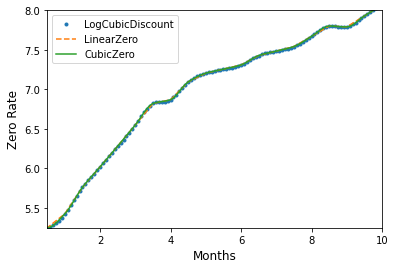

In [56]:
plt.plot(splcd["Maturities"],splcd["Curve"], '.',
label="LogCubicDiscount")
plt.plot(splz["Maturities"],splz["Curve"],'--',
label="LinearZero")
plt.plot(spcz["Maturities"],spcz["Curve"],
label="CubicZero")
plt.xlabel("Months", size=12)
plt.ylabel("Zero Rate", size=12)
plt.xlim(0.5,10)
plt.ylim([5.25,8])
plt.legend(loc=0)